In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
from probabilistic_vq.vector_quantizer import VectorQuantizer
from probabilistic_vq import pass_through
from probabilistic_vq import kl_divergence

In [3]:
class Model(tf.keras.models.Model):
    
    def __init__(self, **kwargs):
        """Build a model using a probabilistic vector quantized hidden layer
        """
        tf.keras.models.Model.__init__(self, **kwargs)
        kwargs = dict(strides=(2, 2), padding='same', data_format='channels_last')
        
        self.conv_layers = []
        self.conv_transpose_layers = []
        
        self.vq = VectorQuantizer(10, 128)
        for i in range(3):
            self.conv_layers.append(
                tf.keras.layers.Conv2D(
                    32 * (2 ** i), 5 if i % 2  == 0 else 4, **kwargs))
            
            self.conv_transpose_layers.append(
                tf.keras.layers.Conv2DTranspose(
                    64 // (2 ** i) if i < 2 else 3, 5 if i % 2  == 0 else 4, **kwargs))
        
    def call(self, images, **kwargs):
        """Forward pass using probabilistic vector quantization on a 
        discrete latent variable model
        
        Arguments:
        images: float32 tensor with shape [batch_dim, height, width, color_dim]
        
        Returns:
        float32 tensor with shape [batch_dim, height, width, color_dim]
        float32 tensor with shape [,]
        """
        x = images
        for i in range(3):
            x = self.conv_layers[i](
                tf.nn.relu(x) if i > 0 else x, **kwargs)
            
        logits = self.vq(x, **kwargs)
        x = self.vq.sample(logits, **kwargs)
        
        for i in range(3):
            x = self.conv_transpose_layers[i](
                tf.nn.relu(x) if i > 0 else x, **kwargs)

        log_p = tf.math.log_softmax(logits)
        uniform_log_p = -tf.math.log(
            tf.fill(tf.shape(logits), tf.cast(tf.shape(logits)[-1], tf.float32)))
        
        return (tf.nn.tanh(x), 
                tf.reduce_mean(kl_divergence(log_p, uniform_log_p)))

In [4]:
model = Model()

In [5]:
dataset = tfds.load(name="cifar10", split="train")
dataset = dataset.repeat(100).shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
optim = tf.keras.optimizers.Adam()

In [7]:
def loss_function(images):
    x, kl_loss = model(images)
    return kl_loss + tf.reduce_mean(
        tf.keras.losses.mean_squared_error(images, x))

MSE: 0.21576647460460663, KL: 1.733067512512207


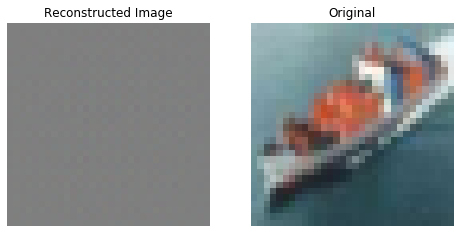

MSE: 0.2780734896659851, KL: 0.007230981253087521


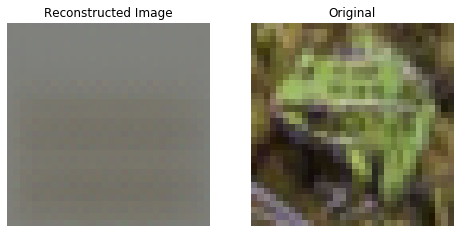

MSE: 0.17972157895565033, KL: 0.003610803047195077


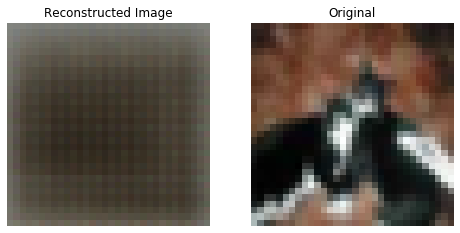

MSE: 0.09799151867628098, KL: 0.002158747287467122


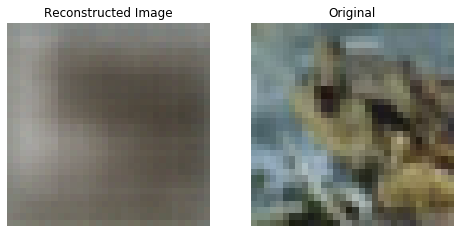

MSE: 0.09215173870325089, KL: 0.0019122736994177103


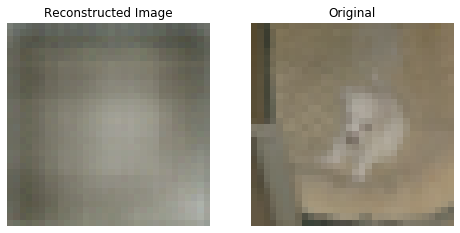

MSE: 0.07285195589065552, KL: 0.001773640513420105


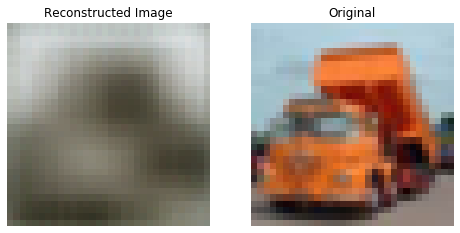

MSE: 0.06705110520124435, KL: 0.001376166008412838


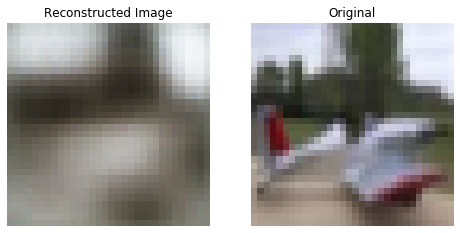

MSE: 0.07138945162296295, KL: 0.0016843036282807589


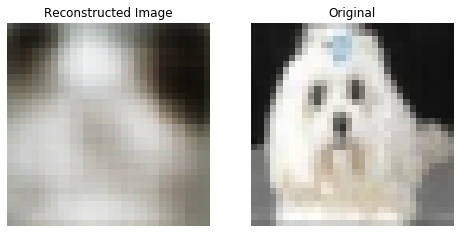

MSE: 0.07616174966096878, KL: 0.0018771342001855373


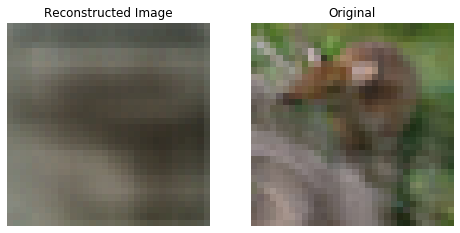

MSE: 0.06812050193548203, KL: 0.0014919531531631947


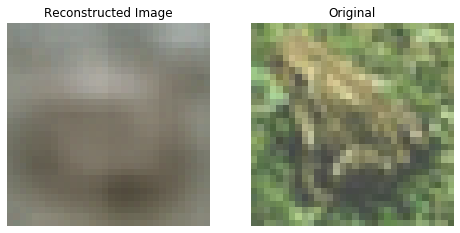

MSE: 0.05936110019683838, KL: 0.0017100642435252666


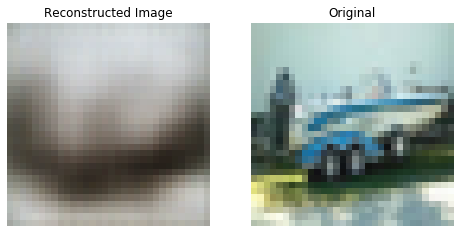

MSE: 0.06736833602190018, KL: 0.0016873071435838938


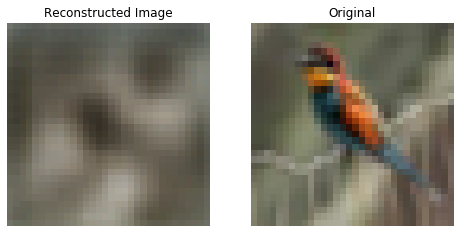

MSE: 0.06504121422767639, KL: 0.0016012894921004772


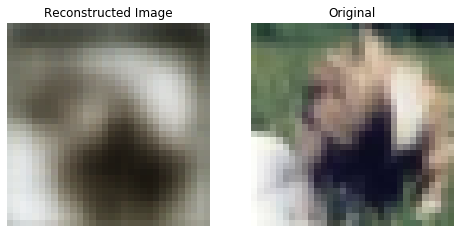

MSE: 0.0526658371090889, KL: 0.001414604252204299


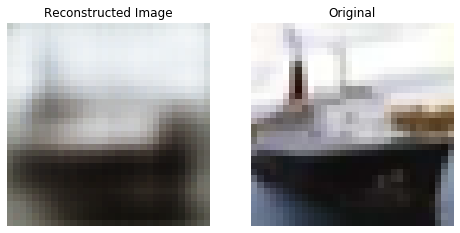

MSE: 0.05705427750945091, KL: 0.0015462535666301847


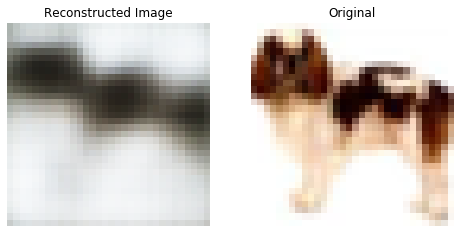

MSE: 0.06551969051361084, KL: 0.0017216692212969065


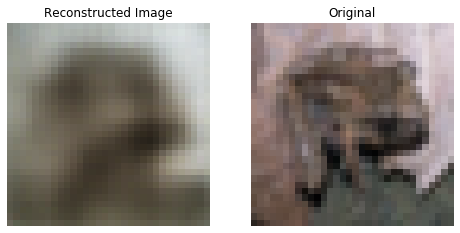

MSE: 0.06401754170656204, KL: 0.00121049745939672


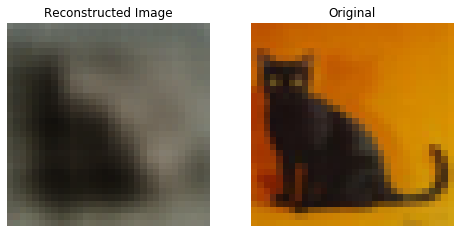

MSE: 0.04306695982813835, KL: 0.0012015715474262834


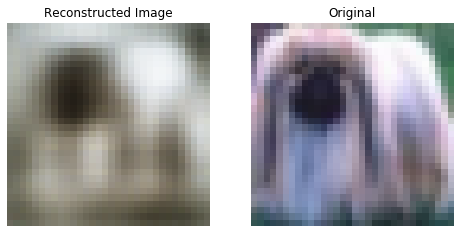

MSE: 0.04726973548531532, KL: 0.001232692040503025


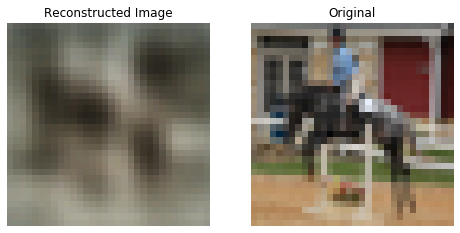

MSE: 0.04836589843034744, KL: 0.0012987926602363586


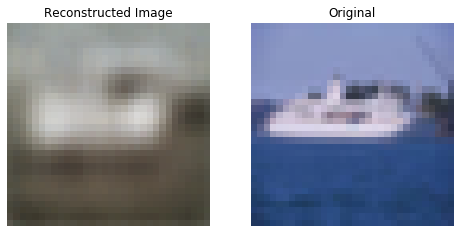

MSE: 0.05510406941175461, KL: 0.0013397420989349484


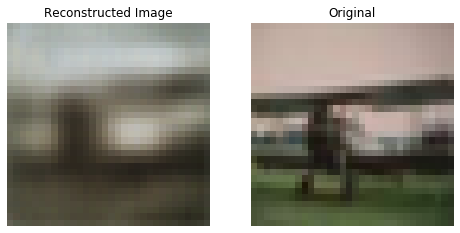

MSE: 0.05531441420316696, KL: 0.0011850502341985703


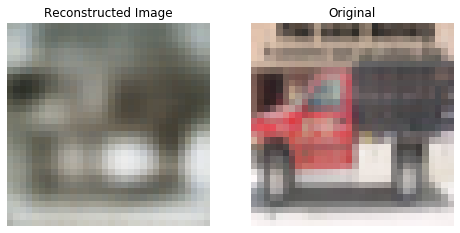

MSE: 0.05551832914352417, KL: 0.0010597680229693651


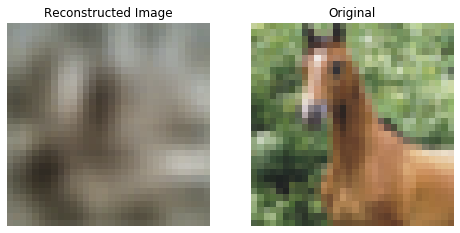

MSE: 0.05162825435400009, KL: 0.0011085509322583675


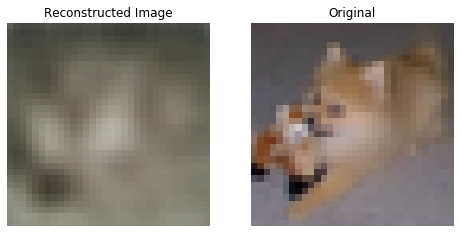

MSE: 0.05212610214948654, KL: 0.001104672672227025


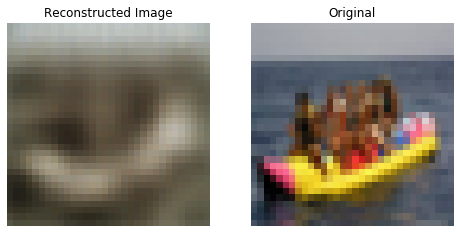

MSE: 0.05333926901221275, KL: 0.001105292234569788


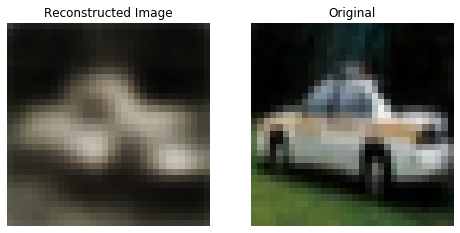

MSE: 0.054694660007953644, KL: 0.0012570639373734593


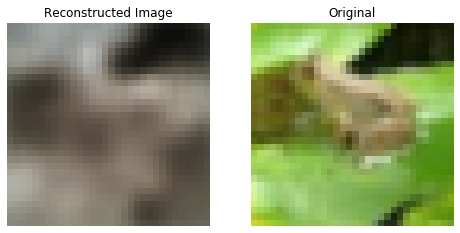

MSE: 0.04599267989397049, KL: 0.0012427683686837554


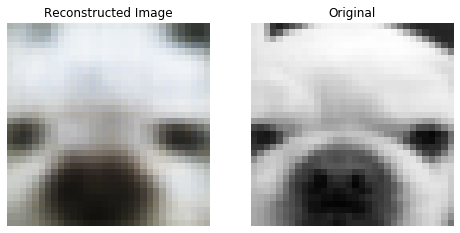

MSE: 0.053990114480257034, KL: 0.0010548767168074846


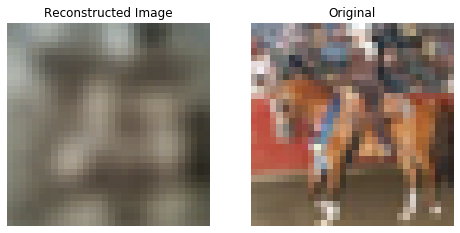

MSE: 0.05800841748714447, KL: 0.0010342233581468463


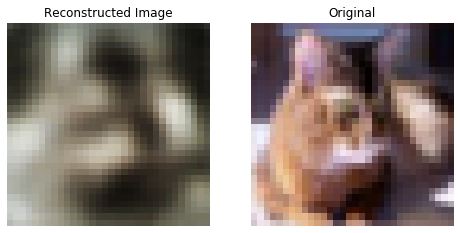

MSE: 0.05230210721492767, KL: 0.0012427528854459524


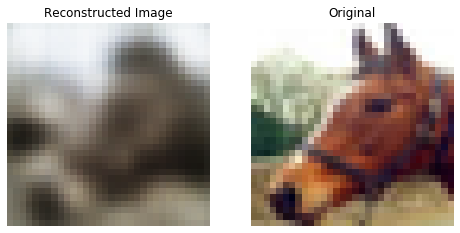

MSE: 0.049575068056583405, KL: 0.0014148475602269173


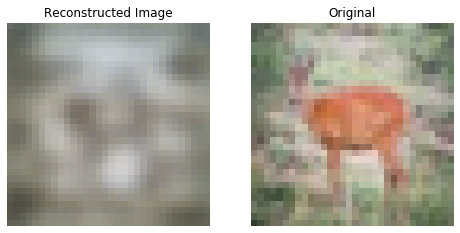

MSE: 0.03726939111948013, KL: 0.0012643184745684266


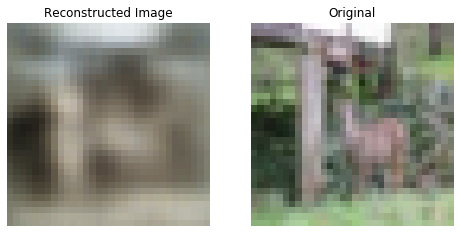

MSE: 0.04403974860906601, KL: 0.0011919992975890636


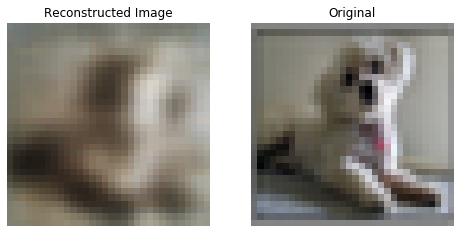

MSE: 0.04173629730939865, KL: 0.001416968647390604


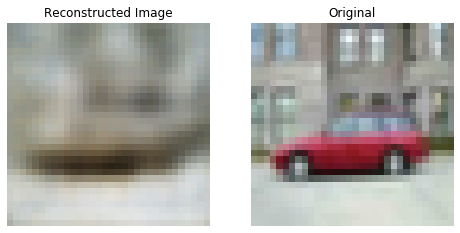

In [ ]:
for i, batch in enumerate(dataset):
    images = batch["image"]
    images = tf.cast(images, tf.float32) / 255.0 * 2.0 - 1.0
    optim.minimize(lambda: loss_function(images), model.trainable_variables)
    
    if i % 100 == 0:
        x, kl_loss = model(images)
        print("MSE: {}, KL: {}".format(
            tf.reduce_mean(tf.keras.losses.mean_squared_error(images, x)), kl_loss))
        
        fig = plt.figure(figsize=(8, 8))
        axes = fig.add_subplot(1, 2, 1)
        axes.set_title("Reconstructed Image")
        axes.set_axis_off()
        plt.imshow(x[0] * 0.5 + 0.5)
        
        axes = fig.add_subplot(1, 2, 2)
        axes.set_title("Original")
        plt.imshow(images[0] * 0.5 + 0.5)
        axes.set_axis_off()
        plt.show()